In [38]:
import os
os.getcwd()

'/media/jdcloud'

In [39]:
import scipy.io as sio
dataset_path = os.getcwd()+"/Train/"
record = "TRAIN0001"
ecg = sio.loadmat(dataset_path+record+'.mat')

In [40]:
ecg.keys()

dict_keys(['V6', 'sex', '__version__', 'aVF', 'I', 'V4', 'V2', 'aVL', 'V1', '__globals__', '__header__', 'II', 'aVR', 'V3', 'III', 'age', 'V5'])

In [41]:
ecg["I"].shape

(1, 5000)

In [42]:
from scipy.signal import butter, lfilter  
import pandas as pd
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing
# from QRSDetectorOffline import QRSDetectorOffline

# DATA_PATH = '../dataset/'


def butter_bandpass(lowcut, highcut, fs, order):  
    nyq = 0.5 * fs  
    low = lowcut / nyq  
    high = highcut / nyq  
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a 


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):  
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)  
    y = lfilter(b, a, data)  
    return y


def get_reference(data_path="../dataset/REFERENCE.csv"):
    # read REFERENCE
    # dataset_path = '../dataset/'
    ref = pd.read_csv(open(data_path,'rU'), encoding='utf-8', engine='c')
    ref.fillna(0, inplace=True)
    # print ref.head()
    # print ref.tail()
    return ref


def get_ecg_label(ref, ind):
    # ref = get_reference()
    label1 = ref.loc[ind, 'First_label']
    label2 = ref.loc[ind, 'Second_label']
    label3 = ref.loc[ind, 'Third_label']
    return label1, label2, label3


def get_ecg_data(ref, ind, data_path="../dataset/", daolian=0, is_filter=False):
    """
    get an ECG data from datasets
    :param ind: the index of samples
    :param is_filter: filter data
    :param daolian:
    :return:
    """
    # ref = get_reference()
    record = ref.loc[ind, 'Recording']
    # read ecg data from mat file and show image
    ecg = sio.loadmat(data_path + record + '.mat')
    ecg = ecg['ECG']
    data = ecg['data'][0][0][daolian]
    if is_filter:
        data = butter_bandpass_filter(data, 1, 40, 500)
    return data


def get_ecg_info(ref, ind, data_path="../dataset/"):
    record = ref.loc[ind, 'Recording']
    # read ecg data from mat file and show image
    ecg = sio.loadmat(data_path + record + '.mat')
    ecg = ecg['ECG']
    sex = ecg['sex'][0][0][0]
    if sex=='Male':
        sex=1
    elif sex=='Female':
        sex=0
    age = ecg['age'][0][0][0][0]
    return sex, age


def get_ecg_channel_data(ref, ind, data_path="../dataset/", is_filter=False):
    """
    get an ECG data from datasets
    :param ind: the index of samples
    :param is_filter: filter data
    :param daolian:
    :return:
    """
    # ref = get_reference()
    record = ref.loc[ind, 'Recording']
    # print record
    # read ecg data from mat file and show image
    ecg = sio.loadmat(data_path + record + '.mat')
    ecg = ecg['ECG']
    data = ecg['data'][0][0]
    if is_filter:
        data = butter_bandpass_filter(data, 1, 40, 500)
    return data


def get_sequence(ecg_data, window, shift):
    """
    generate sequence data for LSTM model
    :param ecg_data:
    :param window: input_dim for a LSTM unit
    :param shift:
    :return:
    """
    assert len(ecg_data) > window
    seq_data = []
    start = 0

    while start + window < len(ecg_data):
        seq_data.append(ecg_data[start:start+window])
        start += shift

    return np.array(seq_data)


def int2(val):
    return int(round(val))


def ht_peak_detect(ecg_heartbeat):
    """
    detect fiducial point of heartbeat
    :param ecg_heartbeat:
    :return:
    """
    hard_peaks, soft_peaks = processing.find_peaks(ecg_heartbeat)
    # print hard_peaks, soft_peaks
    if hard_peaks.size == 0:
        return None
    try:
        r_index = np.where(hard_peaks > 130)[0][0] - 1
        # r_index = np.where(ecg_heartbeat[hard_peaks] == ecg_heartbeat[140])[0][0]
    except IndexError:
        r_index = np.where(ecg_heartbeat[hard_peaks] == max(ecg_heartbeat[hard_peaks]))[0][0]

    # r_index = np.where(ecg_heartbeat[hard_peaks] == max(ecg_heartbeat[hard_peaks]))[0][0]
    # print index
    try:
        q_index = hard_peaks[r_index - 1]
        s_index = hard_peaks[r_index + 1]

        pre = hard_peaks[:r_index - 1]
        fin = hard_peaks[r_index + 1:]
        temp = np.where(ecg_heartbeat[pre] == max(ecg_heartbeat[pre]))[0][0]
        p_index = pre[temp]

        temp = np.where(ecg_heartbeat[fin] == max(ecg_heartbeat[fin]))[0][0]
        t_index = fin[temp]
        return p_index, q_index, r_index, s_index, t_index
    except ValueError:
        return None


def ht_feature(ecg_heartbeat, fs):
    """
    detect fiducial point and extract features(duration and amplitude)
    :param ecg_heartbeat:
    :return:
    """
    x = ht_peak_detect(ecg_heartbeat)
    if x == None:
        return None
    else:
        p_index, q_index, r_index, s_index, t_index = x
    duration = [q_index-p_index, r_index-p_index, r_index-q_index, s_index-r_index, s_index-q_index, t_index-s_index]
    # amplitude = [ecg_heartbeat[r_index] - ecg_heartbeat[p_index],
    #              ecg_heartbeat[r_index] - ecg_heartbeat[q_index],
    #              ecg_heartbeat[r_index] - ecg_heartbeat[s_index],
    #              ecg_heartbeat[r_index] - ecg_heartbeat[t_index],
    #              ecg_heartbeat[t_index] - ecg_heartbeat[s_index],
    #              ecg_heartbeat[p_index] - ecg_heartbeat[q_index]]
    # feature = duration+amplitude
    # return feature
    duration = [x/float(fs) for x in duration]
    return duration

def peak_detect(ecg, fs, view=10, show=False):
    """
    detect the Q, R, and S waves, T waves
    :param ecg: raw ecg vector(list)
    :param fs: sampling frequency(int)
    :param view: display span of the signal(int)
    :param show: show image(bool)
    :return: Pwave_i, Pwave_amp, Qwave_i, Qwave_amp, Rwave_i, Rwave_amp, Swave_i, Swave_amp,Twave_i,Twave_amp,
    """
    P_i = []
    P_amp = []
    Q_i = []
    Q_amp = []
    R_i = []
    R_amp = []
    S_i = []
    S_amp = []
    T_i = []
    T_amp = []

    thres_p = []    # for plotting adaptive threshold
    buffer_plot = []
    buffer_long = []    # buffer for online processing
    c = 0   # counter to determine that the state-machine doesnt get stock in T wave detection wave
    state = 0   # determines the state of the machine in the algorithm
    T_on = 0    # counter showing for how many samples the signal stayed above T wave threshold
    T_on1 = 0   # counter to make sure its the real onset of T wave
    S_on = 0    # counter to make sure its the real onset of S wave
    sleep = 0   # counter that avoids the detection of several R waves in a short time
    S_amp1 = []     # buffer to set the adaptive T wave onset
    buffer_base = []    # buffer to determine online adaptive mean of the signal
    dum = 0     # counter for detecting the exact R wave
    window = 5  # fs / 80     # averaging window size
    weight = 1.8    # initial value of the weigth
    co = 0  # T wave counter to come out of state after a certain time
    thres2_p = []   # T wave threshold indices
    thres_p_i = []      # to save indices of main thres
    S_amp1_i = []   # to save indices of S thres
    thres2_p_i = []     # to save indices of T threshold

    assert len(ecg) > 1     # make sure its a vector
    ecg = butter_bandpass_filter(ecg, 0.5, 40, 500)
    time_scale = len(ecg)/fs

    buffer_mean = np.mean(np.abs(ecg[0:2 * fs] - np.mean(ecg[0:2 * fs])))
    buffer_T = np.mean(ecg[0:2 * fs])
    currentmax = 0
    ind = 0

    for i in range(len(ecg)):
        buffer_long.append(ecg[i])
        buffer_base.append(ecg[i])
        if len(buffer_base) >= 2 * fs:
            buffer_mean = np.mean(np.abs(buffer_base[0:2 * fs] - np.mean(buffer_base[0:2 * fs])))
            buffer_T = np.mean(buffer_base[0:2 * fs])
            buffer_base = []

        if len(buffer_long) >= window:
            mean_online = np.mean(buffer_long)
            buffer_plot.append(mean_online)

            if state == 0:
                if len(buffer_plot) >= 3:
                    if mean_online > buffer_mean*weight and buffer_plot[i-1-window] > buffer_plot[i-window]:
                        state = 1
                        currentmax = buffer_plot[i-2-window]
                        ind = i-1-window
                        thres_p.append(buffer_mean * weight)
                        thres_p_i.append(ind)
                    else:
                        state = 0
            if state == 1:
                if currentmax > buffer_plot[i-window-1]:
                    dum += 1
                    if dum > 3:
                        if len(R_i) - len(S_i) >= 1:
                            S_i.append(-1)
                            S_amp.append(-1)
                        if len(R_i) - len(T_i) >= 1:
                            T_i.append(-1)
                            T_amp.append(-1)
                        #print("test:",window/2)
                        R_i.append(ind+int(window/2)-1)
                        R_amp.append(ecg[ind+int(window/2)-1])

                        try:
                            q_tamp = np.min(buffer_plot[ind-int2(0.08*fs):ind])
                            q_ti = buffer_plot[ind-int2(0.08*fs):ind].index(q_tamp)
                            q_ti = ind - int2(0.08 * fs) + q_ti
                            Q_i.append(q_ti)
                            Q_amp.append(ecg[q_ti])
                        except:
                            Q_i.append(-1)
                            Q_amp.append(-1)

                        try:
                            p_tamp = np.max(buffer_plot[q_ti - int2(0.13 * fs):q_ti - 5])
                            p_ti = buffer_plot[q_ti - int2(0.13 * fs):q_ti - 5].index(p_tamp)
                            p_ti = q_ti - int2(0.13 * fs) + p_ti
                            P_i.append(p_ti)
                            P_amp.append(ecg[p_ti])
                        except:
                            P_i.append(-1)
                            P_amp.append(-1)

                        if len(R_amp) > 8:
                            weight = 0.3 * np.mean(R_amp[-7:-1])
                            weight = weight/buffer_mean

                        state = 2
                        dum = 0
                else:
                    dum = 0
                    state = 0

            if state == 2:
                if mean_online <= buffer_mean:
                    state = 3

            if state == 3:
                co += 1
                if co < int2(0.2*fs):
                    if buffer_plot[i-window-1] <= buffer_plot[i-window]:
                        S_on += 1
                        if S_on >= int2(0.02*fs):
                            S_i.append(i-window-6)
                            S_amp.append(ecg[i-window-6])
                            S_amp1.append(ecg[i-window-6])
                            S_amp1_i.append(ind)     ###############
                            state = 4
                            S_on = 0
                            co = 0
                else:
                    # state = 4
                    co = 0

            if state == 4:
                if mean_online < buffer_mean:
                    state = 6

            if state == 6:
                c += 1
                if c <= int2(0.8*fs):
                    thres2 = np.abs(np.abs(buffer_T)-np.abs(S_amp1[-1]))*3/4 + S_amp1[-1]
                    thres2_p.append(thres2)
                    thres2_p_i.append(ind)
                    if mean_online > thres2:
                        T_on += 1
                        if T_on >= int2(0.02*fs):
                            if buffer_plot[i-window-1] >= buffer_plot[i-window]:
                                T_on1 += 1
                                if T_on1 > int2(0.025*fs):
                                    T_i.append(i-window-7)
                                    T_amp.append(ecg[i-window-7])
                                    state = 5
                                    T_on = 0
                                    T_on1 = 0
                else:
                    state = 5

            if state == 5:
                sleep = sleep + c + 1
                c = 0
                if float(sleep)/fs >= 0.4:
                    state = 0
                    sleep = 0

            del buffer_long[0]

    for index in range(len(P_i)):
        try:
            if P_i[index] == -1:
                continue
            m1 = np.mean(buffer_plot[P_i[index]-25:P_i[index]])
            m2 = np.mean(buffer_plot[P_i[index]:P_i[index]+25])
            if m1 > P_amp[index] or m2 > P_amp[index]:
                # print "P_i: ",P_i[index]
                P_i[index] = Q_i[index]
                P_amp[index] = Q_amp[index]
        except:
            continue

    if len(R_i) - len(S_i) >= 1:
        S_i.append(-1)
        S_amp.append(-1)
    if len(R_i) - len(T_i) >= 1:
        T_i.append(-1)
        T_amp.append(-1)

    # print P_i
    # # print P_amp
    # print Q_i
    # # print Q_amp
    # print R_i
    # # print R_amp
    # print S_i
    # print T_i

    Pwave_i = []
    Pwave_amp = []
    Qwave_i = []
    Qwave_amp = []
    Rwave_i = []
    Rwave_amp = []
    Swave_i = []
    Swave_amp = []
    Twave_i = []
    Twave_amp = []

    assert len(P_i) == len(Q_i) and len(Q_i) == len(R_i) and len(R_i) == len(S_i) and len(T_i) == len(S_i)
    for i in range(len(P_i)):
        if P_i[i] == -1 or Q_i[i] == -1 or R_i[i] == -1 or S_i[i] == -1 or T_i[i] == -1:
            continue
        else:
            Pwave_i.append(P_i[i])
            Pwave_amp.append(P_amp[i])
            Qwave_i.append(Q_i[i])
            Qwave_amp.append(Q_amp[i])
            Rwave_i.append(R_i[i])
            Rwave_amp.append(R_amp[i])
            Swave_i.append(S_i[i])
            Swave_amp.append(S_amp[i])
            Twave_amp.append(T_amp[i])
            Twave_i.append(T_i[i])

    if show:
        v = view*fs
        plt.figure(figsize=(18,8))
        plt.plot(ecg[:v], linewidth='0.8')
        # print Pwave_i
        # # print P_amp
        # print Qwave_i
        # # print Q_amp
        # print Rwave_i
        # # print R_amp
        # print Swave_i
        # print Twave_i
        plt.scatter(Pwave_i[:view], Pwave_amp[:view], marker='o', c='g', s=60, alpha=0.5)
        plt.scatter(Qwave_i[:view], Qwave_amp[:view], marker='o', c='r', s=60, alpha=0.5)
        plt.scatter(Rwave_i[:view], Rwave_amp[:view], marker='o', c='k', s=60, alpha=0.5)
        plt.scatter(Swave_i[:view], Swave_amp[:view], marker='o', c='m', s=60, alpha=0.5)
        plt.scatter(Twave_i[:view], Twave_amp[:view], marker='o', c='b', s=60, alpha=0.5)
        plt.show()
    return Pwave_i, Pwave_amp, Qwave_i, Qwave_amp, Rwave_i, Rwave_amp, Swave_i, Swave_amp, Twave_i, Twave_amp


def get_heartbeats(ecg_data, fs, method=0, left=None, right=None, label=0):
    """
    get heartbeats from ECG recording
    :param ecg_data:
    :param fs:
    :param method: 0-peak_detect; 1-wfdb
    :param left:
    :param right:
    :return:
    """
    if left == None and right == None:
        # left = [130, 128, 126, 132]
        # right = [200, 202, 204, 198]
        if label == 1 or label==6 or label == 7 or label==9:
            left = [130, 128, 126, 132]
            right = [200, 202, 204, 198]
        else:
            left = [130]
            right = [200]
    if method == 0:
        Pwave_i, Pwave_amp, Qwave_i, Qwave_amp, Rwave_i, Rwave_amp, Swave_i, Swave_amp, Twave_i, Twave_amp, = peak_detect(
        ecg_data, fs)
    elif method == 1:
        ecg_data = butter_bandpass_filter(ecg_data, 0.5, 40, 500)
        xqrs = processing.XQRS(ecg_data, fs)
        xqrs.detect(verbose=False)
        # remove_rpeak(sig, xqrs.qrs_inds)
        # Rwave_i = remove_rpeak(ecg_data, xqrs.qrs_inds)
        Rwave_i = xqrs.qrs_inds

    heartbeats = []
    # for p_i, t_i in zip(Pwave_i, Twave_i):
    #     # print "pi:%d, ti:%d" % (p_i, t_i)
    #     if p_i-left > 0 and t_i+right < len(ecg_data):
    #         heartbeats.append(ecg_data[p_i-40:t_i+40])
    for z_i, z_j in zip(left, right):
        for r_i in Rwave_i:
        # print "pi:%d, ti:%d" % (p_i, t_i)

            if r_i-z_i > 0 and r_i + z_j < len(ecg_data):
                heartbeats.append(ecg_data[r_i-z_i:r_i+z_j])

    return heartbeats


# def get_R(ecg_data, fs):


def get_mul_heartbeats(ecg_data, fs, length):
    ecg_data = butter_bandpass_filter(ecg_data, 0.5, 40, fs)
    heartbeats = []
    start=0
    while(start < len(ecg_data)-length):
        heartbeats.append(ecg_data[start:start+length])
        start+=length

    return heartbeats


def data_norm(result):
    result_mean = result.mean()
    result_std = result.std()+0.000001
    result -= result_mean
    result /= result_std
    return result


def test_wfdb(sig, method_type=0):
    import wfdb
    from wfdb import processing
    sig = butter_bandpass_filter(sig, 0.5, 40, 500)
    if method_type == 0:
        xqrs = processing.XQRS(sig, 500)
        xqrs.detect()
        print(type(xqrs.qrs_inds))
        qrs = xqrs.qrs_inds
        qrs = remove_rpeak(sig, xqrs.qrs_inds)
        # print r
        wfdb.plot_items(sig, ann_samp=[qrs])
    elif method_type == 1:
        qrs_inds = processing.xqrs_detect(sig, 500)
        wfdb.plot_items(sig, ann_samp=[qrs_inds])
    elif method_type == 2:
        qrs_inds = processing.gqrs_detect(sig, 500)
        wfdb.plot_items(sig, ann_samp=[qrs_inds])


def remove_rpeak(sig, qrs):
    amplitude = [sig[x] for x in qrs]
    mean = np.mean(amplitude)
    qrs = [x for x in qrs if sig[x] > mean*0.65]
    return np.array(qrs)


def autocorr(x):
    result = np.correlate(x, x, mode='full')
    # return result
    return result[result.size/2:]

    # xqrs = processing.XQRS(ecg_data, fs)
    # xqrs.detect(verbose=False, learn=False)
    # # remove_rpeak(sig, xqrs.qrs_inds)
    # # Rwave_i = remove_rpeak(ecg_data, xqrs.qrs_inds)
    # Rwave_i = xqrs.qrs_inds
    # print Rwave_i
    #
    # ecg = ecg_data[Rwave_i[1]-140:Rwave_i[1]+200]
    #
    # hard_peaks, soft_peaks = processing.find_peaks(ecg)
    # # qrs_inds = wp.xqrs_detect(ecg, 500)
    # # print hard_peaks
    # # plt.plot(ecg_data)
    # # plt.scatter(hard_peaks, ecg[hard_peaks], marker='o', c='r')
    # # plt.scatter(soft_peaks, ecg[soft_peaks], marker='*', c='b')
    # print hard_peaks
    # # ss = abs(hard_peaks-140)
    # # ss.sort()
    #
    # # print index
    #
    # # index = np.where(ecg[hard_peaks] == max(ecg[hard_peaks]))[0][0]
    # try:
    #     print "hhaaa"
    #     index = np.where(hard_peaks > 140)[0][0] - 1
    # except IndexError:
    #     print "sfsdfsdfsdf"
    #     index = np.where(ecg[hard_peaks] == max(ecg[hard_peaks]))[0][0]
    # print index
    #
    # try:
    #     q = hard_peaks[index-1]
    #     s = hard_peaks[index+1]
    #     plt.scatter(hard_peaks[index], ecg[hard_peaks[index]], marker='o', c='r')
    #     plt.scatter(hard_peaks[index-1], ecg[hard_peaks[index-1]], marker='*', c='g')
    #     plt.scatter(hard_peaks[index+1], ecg[hard_peaks[index+1]], marker='*', c='b')
    # except IndexError:
    #     plt.plot(ecg)
    #     plt.show()
    #
    # # print q, s
    # try:
    #     pre = hard_peaks[:index - 1]
    #     fin = hard_peaks[index+1:]
    #     temp = np.where(ecg[pre] == max(ecg[pre]))[0][0]
    #     p = pre[temp]
    #
    #     temp = np.where(ecg[fin] == max(ecg[fin]))[0][0]
    #     t = fin[temp]
    #
    #     plt.scatter(p, ecg[p], marker='*', c='r')
    #     plt.scatter(t, ecg[t], marker='*', c='r')
    # except ValueError:
    #     print "error"
    # except IndexError:
    #     plt.plot(ecg)
    #     plt.show()
    #     print "error"
    #
    # # plt.scatter(Rwave_i, ecg[Rwave_i], marker='o', c='g')
    # # plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
    #
    #
    # # peak_detect(ecg, 500, show=True)
    # # test_wfdb(ecg_data, 0)
    # # hearts = get_heartbeats(ecg_data, 500, 1)
    # # print hearts[11]
    # plt.plot(ecg)
    # plt.show()


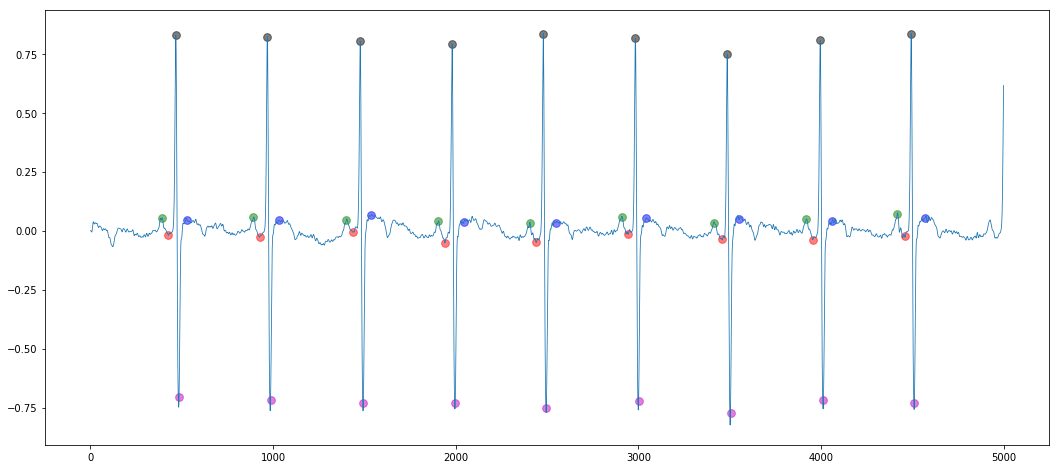

([391, 892, 1401, 1904, 2404, 2908, 3411, 3918, 4417],
 [0.05175327173874206,
  0.056217754583340794,
  0.04683361141554698,
  0.0393389624579747,
  0.03151482537496554,
  0.05916787883685322,
  0.034481488333570676,
  0.04810652918628496,
  0.07144964426705946],
 [426, 927, 1436, 1939, 2438, 2942, 3456, 3954, 4457],
 [-0.01901448883814361,
  -0.0265071310648611,
  -0.0066044666771772915,
  -0.05046521296700392,
  -0.047132453427852855,
  -0.014622869773671617,
  -0.03668413639066069,
  -0.038093631880199826,
  -0.023724801813900985],
 [467, 968, 1477, 1980, 2479, 2983, 3486, 3995, 4493],
 [0.8297902225156056,
  0.8226444506838486,
  0.8030022999111956,
  0.7930426022575343,
  0.8360353312951165,
  0.8150881073832078,
  0.7494001333062059,
  0.8068849638455597,
  0.8359788495765735],
 [485, 986, 1494, 1997, 2496, 3001, 3504, 4013, 4511],
 [-0.7048334974257164,
  -0.7197129566013023,
  -0.7324235927666344,
  -0.730968763524944,
  -0.7512951615810406,
  -0.7231002570093025,
  -0.77373248

In [43]:
peak_detect(ecg["V2"][0], 500, 10, 1)

In [44]:
import pandas as pd
labels = pd.read_csv("reference.csv")
labels.head()

,File_name,label1,label2,label3,label4,label5,label6,label7,label8
0,TRAIN0001,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN0002,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAIN0003,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN0004,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TRAIN0005,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 0 - Normal; 1 - AF; 2 - FDAVB; 3 - CRBBB; 4 - LAFB; 5 - PVC; 6 - PAC; 7 - ER; 8 - TWC

In [45]:
sum_label = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0}
for i in range(1,9,1):
    for j in range(9):
        sum_label[str(j)] += labels.loc[labels["label"+str(i)]==j].shape[0]
sum_label

{'0': 1953,
 '1': 504,
 '2': 534,
 '3': 826,
 '4': 180,
 '5': 654,
 '6': 672,
 '7': 224,
 '8': 2156}

In [46]:
ecg_data = ecg["V2"][0]

In [47]:
import wfdb.processing as wp
qrs_inds = wp.xqrs_detect(ecg_data, 500)

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


In [48]:
"""
Copyright (c) 2013 Jami Pekkanen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import sys
import numpy as np
import scipy.signal
import scipy.ndimage


def detect_beats(
        ecg,    # The raw ECG signal
        rate,    # Sampling rate in HZ
        # Window size in seconds to use for 
        ransac_window_size=5.0,
        # Low frequency of the band pass filter
        lowfreq=5.0,
        # High frequency of the band pass filter
        highfreq=15.0,
        ):
    """
    ECG heart beat detection based on
    http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
    with some tweaks (mainly robust estimation of the rectified signal
    cutoff threshold).
    """

    ransac_window_size = int(ransac_window_size*rate)

    lowpass = scipy.signal.butter(1, highfreq/(rate/2.0), 'low')
    highpass = scipy.signal.butter(1, lowfreq/(rate/2.0), 'high')
    # TODO: Could use an actual bandpass filter
    ecg_low = scipy.signal.filtfilt(*lowpass, x=ecg)
    ecg_band = scipy.signal.filtfilt(*highpass, x=ecg_low)
    
    # Square (=signal power) of the first difference of the signal
    decg = np.diff(ecg_band)
    decg_power = decg**2
    
    # Robust threshold and normalizator estimation
    thresholds = []
    max_powers = []
    for i in range(int(len(decg_power)/ransac_window_size)):
        sample = slice(i*ransac_window_size, (i+1)*ransac_window_size)
        d = decg_power[sample]
        thresholds.append(0.5*np.std(d))
        max_powers.append(np.max(d))

    threshold = 0.5*np.std(decg_power)
    threshold = np.median(thresholds)
    max_power = np.median(max_powers)
    decg_power[decg_power < threshold] = 0

    decg_power /= max_power
    decg_power[decg_power > 1.0] = 1.0
    square_decg_power = decg_power**2

    shannon_energy = -square_decg_power*np.log(square_decg_power)
    shannon_energy[~np.isfinite(shannon_energy)] = 0.0

    mean_window_len = int(rate*0.125+1)
    lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
    #lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)
    
    lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate/8.0)
    lp_energy_diff = np.diff(lp_energy)

    zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
    zero_crossings = np.flatnonzero(zero_crossings)
    zero_crossings -= 1
    return zero_crossings


def plot_peak_detection(ecg, rate):
    import matplotlib.pyplot as plt
    dt = 1.0/rate
    t = np.linspace(0, len(ecg)*dt, len(ecg))
    plt.plot(t, ecg)

    peak_i = detect_beats(ecg, rate)
    plt.scatter(t[peak_i], ecg[peak_i], color='red')
    plt.show()

In [49]:
import pywt
def pywtfilt(sig):
    coeffs = pywt.wavedec(sig,'db6',level=9)
    coeffs[-1] = np.zeros(len(coeffs[-1]))
    coeffs[-2] = np.zeros(len(coeffs[-2]))
    coeffs[0] = np.zeros(len(coeffs[0]))
    
    sig_filt = pywt.waverec(coeffs,'db6')
    return sig_filt

In [52]:
from features_st.biosppy import ecg
ecg_object = ecg.ecg(signal=ecg_data[0], sampling_rate=500, show=False)
# Get BioSPPy output
ts = ecg_object['ts']                        # Signal time array
rpeaks = ecg_object['rpeaks']                # rpeak indices

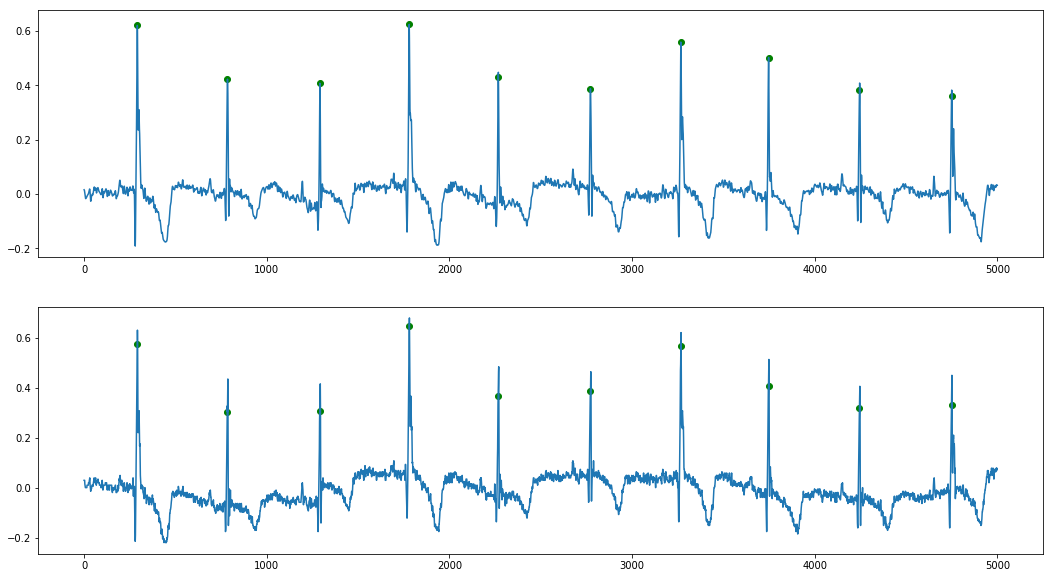

In [74]:
import wfdb.processing as wp
import warnings
import numpy as np
import matplotlib.pyplot as plt
from features_st.biosppy import ecg
warnings.filterwarnings('ignore')
record = "TRAIN1817"
ecg12 = sio.loadmat(dataset_path+record+'.mat')
ecg_data= []
ecg_data.append(pywtfilt(ecg12["III"][0]))
ecg_data.append(ecg12["III"][0])
hard_peaks, soft_peaks = wp.find_peaks(ecg_data[0])
ecg_object = ecg.ecg(signal=ecg_data[0], sampling_rate=500, show=False)
# Get BioSPPy output
ts = ecg_object['ts']                        # Signal time array
rpeaks = ecg_object['rpeaks']                # rpeak indices

qrs_inds = rpeaks#wp.xqrs_detect(ecg_data[0], 500)#detect_beats(ecg_data[0], 500)#wp.xqrs_detect(ecg_data[0], 500)
plt.figure(figsize=(18,10))

for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.plot(ecg_data[i])
    #plt.scatter(hard_peaks, ecg_data[hard_peaks], marker='o', c='r')
    plt.scatter(qrs_inds, ecg_data[i][qrs_inds], marker='o', c='g')
    #plt.plot(soft_peaks)
plt.show()


In [76]:
ecg12_data=[]
for k,v in ecg12.items():
    if k in ["__header__","__globals__","__version__"]:
        continue
    elif k in ["sex","age"]:
        continue
    else:
        ecg12_data.append(v[0])
ecg12 = np.array(ecg12_data)

### 0 - Normal; 1 - AF; 2 - FDAVB; 3 - CRBBB; 4 - LAFB; 5 - PVC; 6 - PAC; 7 - ER; 8 - TWC

In [77]:
labels.loc[labels['File_name']== record]

,File_name,label1,label2,label3,label4,label5,label6,label7,label8
1816,TRAIN1817,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


<Figure size 1440x1440 with 0 Axes>

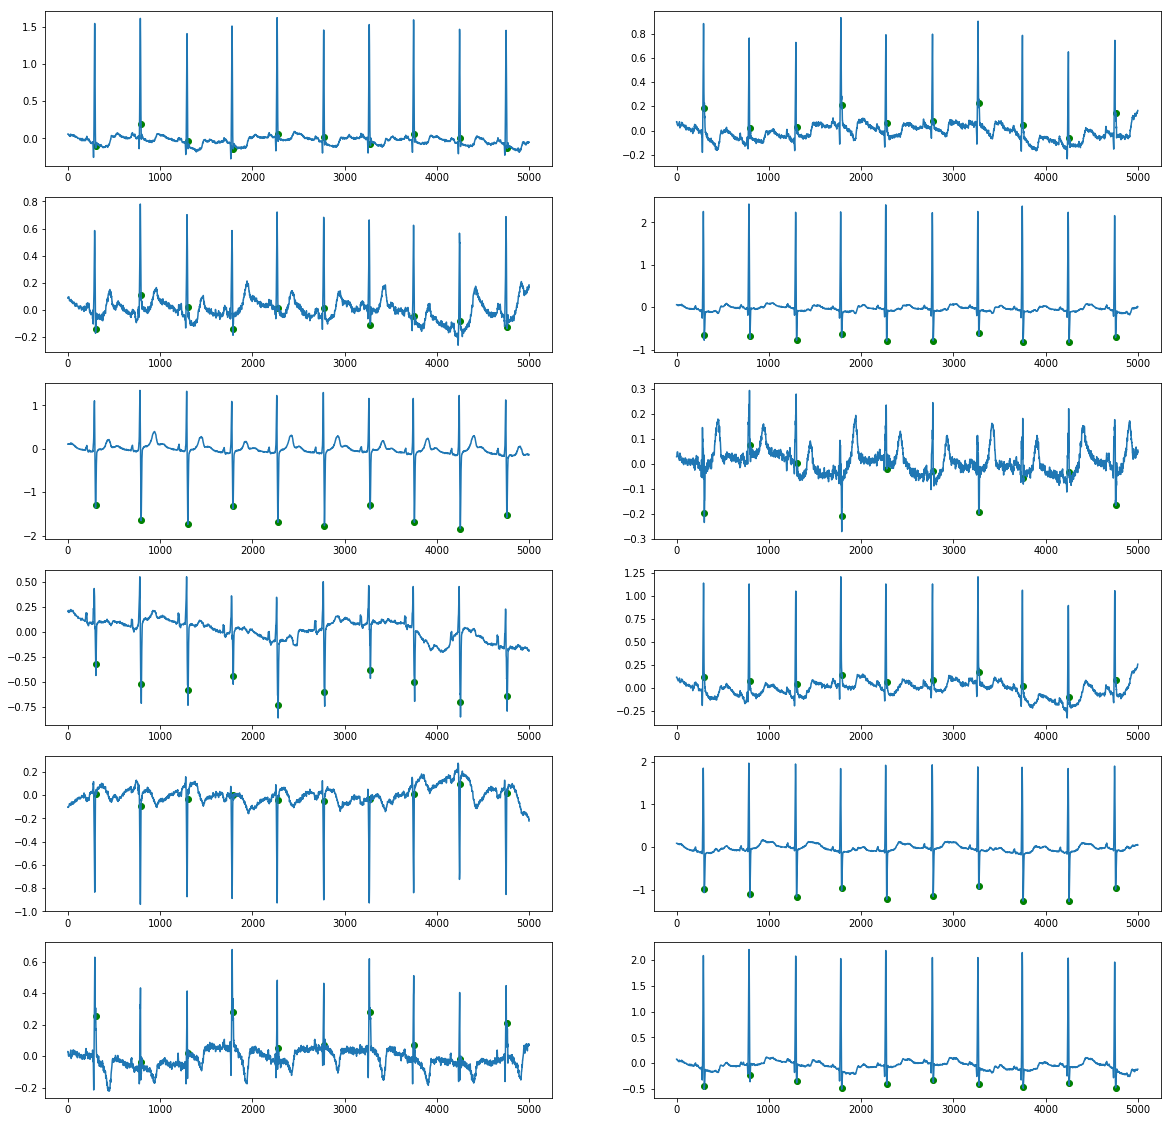

In [78]:
plt.figure(figsize=(20,20))
ecg_data = ecg12[6]
hard_peaks, soft_peaks = wp.find_peaks(ecg_data)
qrs_inds = wp.xqrs_detect(ecg_data, 500)
for i in range(12):
    plt.subplot(6, 2, i+1)
    ecg_data = ecg12[i]
    #hard_peaks, soft_peaks = wp.fi nd_peaks(ecg_data)
    #qrs_inds = wp.xqrs_detect(ecg_data, 500)
    # # print hard_peaks
    #plt.figure(figsize=(18,8))
    plt.plot(ecg_data)
    #plt.scatter(hard_peaks, ecg_data[hard_peaks], marker='o', c='r')
    plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
#plt.plot(soft_peaks)
#print("labels : ",labels[labels[0] == record][1].values)
plt.show()